<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

<H3 align='center'> Integrantes </H3>
<H5 align='center'> Francisco Farías 201573601-4</H5>
<H5 align='center'> Francisco Solar 201573524-7</H5>
<hr style="height:2px;border:none"/>


**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

**Formalidades**  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Ensamblados para regresión  
[2.](#segundo) Detección de acoso en *Twitter*  

<a id="primero"></a>
## 1. Ensamblados para regresión
---
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.

---
    

>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.
```python

In [29]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.

In [30]:
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date


> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.

In [31]:
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.


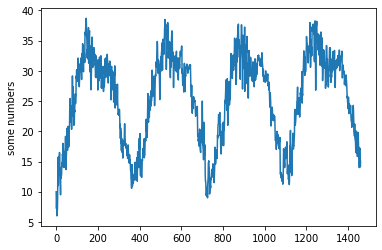

,meantemp,humidity,wind_speed,meanpressure,cday,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,2,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,3,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,4,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,5,2013,1,0,0,0,1


In [32]:
import matplotlib.pyplot as plt
plt.ylabel('some numbers')
plt.plot(list(range(0,1461)), df['meantemp'])
plt.show()
df.head()

Tomando en cuenta la informacion mostrada por el grafico, en donde se muestra la temperatura promedio durante 1400 dias se puede ver una relacion casi lineal o predecible el cual se repite periodicamente, pero no es factible utilizar solo la informacion del dia anterior, se necesita un contexto para esta informacion.

In [33]:
X_train.shape
X_val.shape

(461, 11)

> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?


In [34]:
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model

model_unr2 = Tree(ccp_alpha=0.001,max_leaf_nodes=10) #regularized model -- default parameters
model_unr2.fit(X_train,y_train)



DecisionTreeRegressor(ccp_alpha=0.001, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

No es necesario debido a la forma en la que los arboles hacen sus particiones, lo que los hace invariantes a los cambios en los datos mientras estos mantengan el orden (se haga una escala)

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.


In [35]:
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

y_train_hat2 = model_unr2.predict(X_train)
y_val_hat2 = model_unr2.predict(X_val)
print("RMSE train2= ",RMSE(y_train,y_train_hat2))
print("RMSE val2= ",RMSE(y_val,y_val_hat2))

RMSE train=  0.0
RMSE val=  2.487256728390081
RMSE train2=  1.7641974666414988
RMSE val2=  1.710103579322911


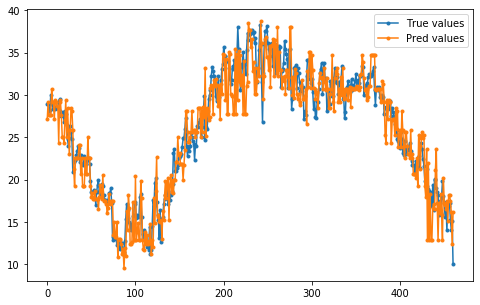

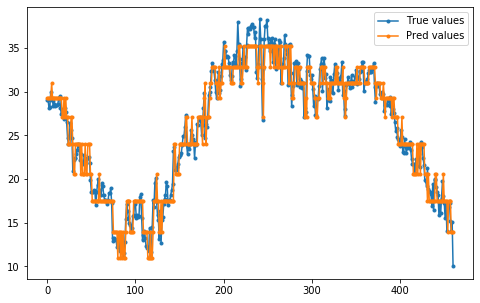

In [36]:
import matplotlib.pyplot as plt
import matplotlib
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()


plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat2, '.-' ,label="Pred values")
plt.legend()
plt.show()

Se puede ver que cuando se hicieron las modificaciones en el arbol ( se regularizo el ccp_alpha y el max_leaf_nodes) aumentó el error en el set de entrenamiento, pero disminuyó en el set de validacion. Por otro lado de los gráficos se puede ver que en el regularizado los valores predecidos tienden a ser la media de los datos cercanos.

> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [37]:
from sklearn.ensemble import BaggingRegressor
'''
model = BaggingRegressor(base_estimator=Tree(), n_estimators=150, n_jobs=-1)
model.fit(X_train,y_train)
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)

print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

model2 = BaggingRegressor(base_estimator=Tree(ccp_alpha=0.001,max_leaf_nodes=10), n_estimators=150, n_jobs=-1)
model2.fit(X_train,y_train)
y_train_hat2 = model2.predict(X_train)
y_val_hat2 = model2.predict(X_val)
print("RMSE train2= ",RMSE(y_train,y_train_hat2))
print("RMSE val2= ",RMSE(y_val,y_val_hat2))
'''
paramet=[1,10,100,250,500,750,1000]

val_br_train=[]
val_bnr_train=[]
val_br_val=[]
val_bnr_val=[]
modelos_br= []
modelos_bnr = []

for i in paramet:
    model = BaggingRegressor(base_estimator=Tree(), n_estimators=i, n_jobs=-1)

    model.fit(X_train,y_train)
    modelos_bnr.append(model)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
  
    val_br_train.append(RMSE(y_train,y_train_hat))
    val_br_val.append(RMSE(y_val,y_val_hat))
    
    model2 = BaggingRegressor(base_estimator=Tree(ccp_alpha=0.001,max_leaf_nodes=10), n_estimators=i, n_jobs=-1,oob_score=True)
    model2.fit(X_train,y_train)
    modelos_br.append(model2)
    y_train_hat2 = model2.predict(X_train)
    y_val_hat2 = model2.predict(X_val)
    val_bnr_train.append(RMSE(y_train,y_train_hat2))
    val_bnr_val.append(RMSE(y_val,y_val_hat2))


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


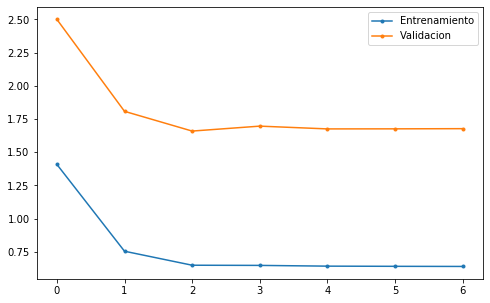

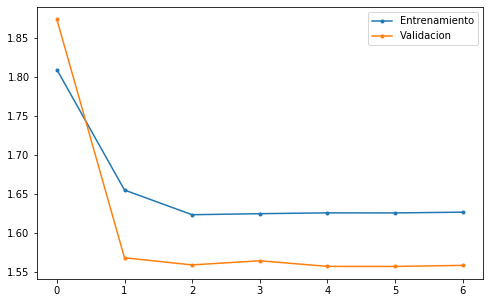

In [38]:
plt.figure(figsize=(8,5))
plt.plot(val_br_train, '.-' ,label="Entrenamiento")
plt.plot(val_br_val, '.-' ,label="Validacion")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(val_bnr_train, '.-' ,label="Entrenamiento")
plt.plot(val_bnr_val, '.-' ,label="Validacion")
plt.legend()
plt.show()

Se puede ver por los gráficos, la gran diferencia entre los dos arboles mediante una regularizacion, ya que en el segundo es claro que no existe overfitting.

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).


In [39]:
from sklearn.ensemble import AdaBoostRegressor

'''model = AdaBoostRegressor(base_estimator=Tree(), n_estimators=150)
model.fit(X_train,y_train)
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)

print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))


model2 = AdaBoostRegressor(base_estimator=Tree(ccp_alpha=0.001,max_leaf_nodes=10), n_estimators=150)
model2.fit(X_train,y_train)
y_train_hat2 = model2.predict(X_train)
y_val_hat2 = model2.predict(X_val)
print("RMSE train2= ",RMSE(y_train,y_train_hat2))
print("RMSE val2= ",RMSE(y_val,y_val_hat2))
'''

val_adar_train=[]
val_adanr_train=[]
val_adar_val=[]
val_adanr_val=[]

for i in paramet:
    
    model = AdaBoostRegressor(base_estimator=Tree(), n_estimators=i)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    val_adanr_train.append(RMSE(y_train,y_train_hat))
    val_adanr_val.append(RMSE(y_val,y_val_hat))
    
    model2 = AdaBoostRegressor(base_estimator=Tree(ccp_alpha=0.001,max_leaf_nodes=10), n_estimators=i)
    model2.fit(X_train,y_train)
    y_train_hat2 = model2.predict(X_train)
    y_val_hat2 = model2.predict(X_val)
    val_adar_train.append(RMSE(y_train,y_train_hat2))
    val_adar_val.append(RMSE(y_val,y_val_hat2))
    


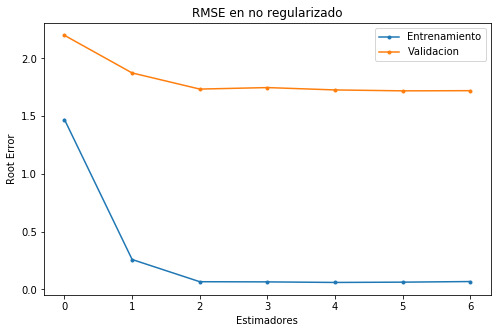

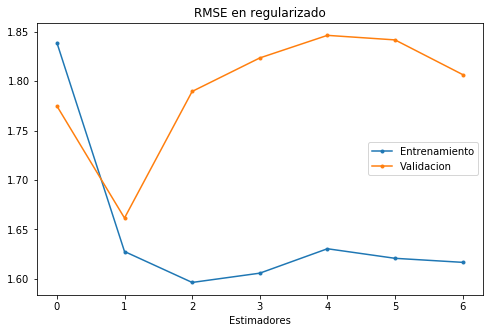

In [40]:
plt.figure(figsize=(8,5))
plt.plot(val_adanr_train, '.-' ,label="Entrenamiento")
plt.plot(val_adanr_val, '.-' ,label="Validacion")
plt.legend()
plt.ylabel('Root Error')
plt.xlabel('Estimadores')
plt.title("RMSE en no regularizado")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(val_adar_train, '.-' ,label="Entrenamiento")
plt.plot(val_adar_val, '.-' ,label="Validacion")
plt.legend()
plt.xlabel('Estimadores')
plt.title("RMSE en regularizado")
plt.show()

Al ver los errores del conjunto de entrenamiento del arbol no regularizado se puede ver que no hay overfitting, mientras que en el árbol regularizado podemos  ver que es lo contrario, además podemos observar que el RMSE disminuye en el árbol regularizado, por lo que al variar el hyperparametro, mejora el modelo

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


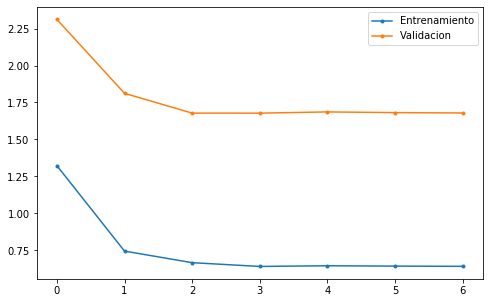

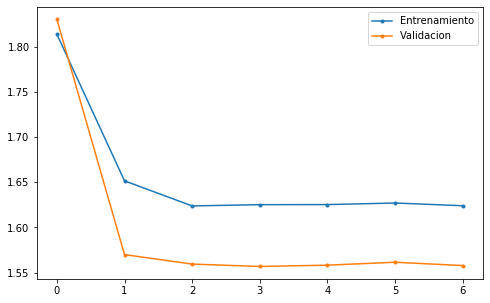

In [41]:
from sklearn.ensemble import RandomForestRegressor

train=[]
val=[]
train2=[]
val2=[]
train_rfreg = []
val_rfreg = []
train_rfnreg = []
val_rfnreg = []
modelos_rdmfr = []
modelos_rdmfnr = []
for i in paramet:
    model=RandomForestRegressor(n_estimators=i,n_jobs=-1)
    model.fit(X_train,y_train)
    modelos_rdmfnr.append(model)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    train_rfnreg.append(RMSE(y_train,y_train_hat))
    val_rfnreg.append(RMSE(y_val,y_val_hat))
    

    model2=RandomForestRegressor(n_estimators=i,ccp_alpha=0.001,max_leaf_nodes=10,n_jobs=-1,oob_score=True)
    model2.fit(X_train,y_train)
    modelos_rdmfr.append(model2)
    y_train_hat2 = model2.predict(X_train)
    y_val_hat2 = model2.predict(X_val)
    train_rfreg.append(RMSE(y_train,y_train_hat2))
    val_rfreg.append(RMSE(y_val,y_val_hat2))
    

plt.figure(figsize=(8,5))
plt.plot(train_rfnreg, '.-' ,label="Entrenamiento")
plt.plot(val_rfnreg, '.-' ,label="Validacion")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_rfreg, '.-' ,label="Entrenamiento")
plt.plot(val_rfreg, '.-' ,label="Validacion")
plt.legend()
plt.show()

Al ver los errores del conjunto de entrenamiento del arbol no regularizado se puede ver una tendencia al overfitting la cual es inexistente con el arbol regularizado. al igual que en los ultimos gráficos vistos


> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).


OOB error:  [True, True, True, True, True, True, True]
Val error:  [0.9300856466808654, 0.9509956347559219, 0.951564875027822, 0.9512345439084698, 0.951681935529189, 0.9516867249808642, 0.9516011067617456]
OOB error:  [False, False, False, False, False, False, False]
Val error:  [0.8754395415534213, 0.934884647694658, 0.9451518885763615, 0.9426665123035822, 0.9440705236405579, 0.9440362704257078, 0.943946468419507]


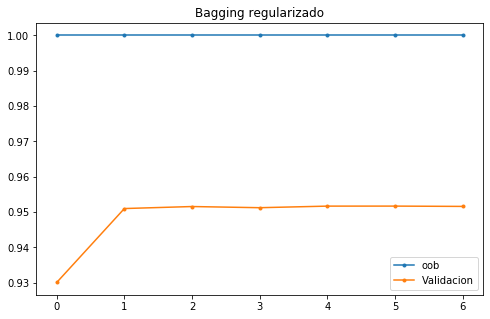

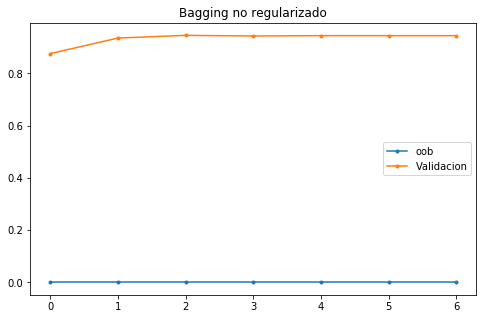

In [42]:
oob_br = []
val_br = []
oob_bnr = []
val_bnr = []

for i in modelos_br:
    oob_error = i.oob_score
    val_error = i.score(X_val,y_val)
    oob_br.append(oob_error)
    val_br.append(val_error)

for i in modelos_bnr:
    oob_error = i.oob_score
    val_error = i.score(X_val,y_val)
    oob_bnr.append(oob_error)
    val_bnr.append(val_error)

print("OOB error: ",oob_br)
print ("Val error: ",val_br)
print("OOB error: ",oob_bnr)
print ("Val error: ",val_bnr)

plt.figure(figsize=(8,5))
plt.plot(oob_br, '.-' ,label="oob")
plt.plot(val_br, '.-' ,label="Validacion")
plt.legend()
plt.title("Bagging regularizado")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(oob_bnr, '.-' ,label="oob")
plt.plot(val_bnr, '.-' ,label="Validacion")
plt.legend()
plt.title("Bagging no regularizado")
plt.show()

Podemos observar que en el modelo de bagging regularizado los valores son parecidos, por lo tanto podría usarse como metrica de generalización

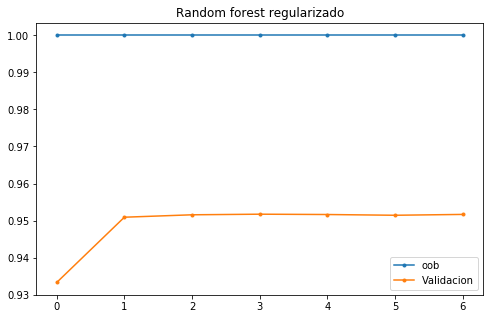

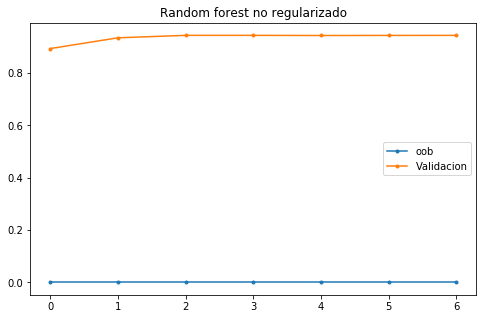

In [43]:
oob_br = []
val_br = []
oob_bnr = []
val_bnr = []

for i in modelos_rdmfr:
    oob_error = i.oob_score
    val_error = i.score(X_val,y_val)
    oob_br.append(oob_error)
    val_br.append(val_error)

for i in modelos_rdmfnr:
    oob_error = i.oob_score
    val_error = i.score(X_val,y_val)
    oob_bnr.append(oob_error)
    val_bnr.append(val_error)


plt.figure(figsize=(8,5))
plt.plot(oob_br, '.-' ,label="oob")
plt.plot(val_br, '.-' ,label="Validacion")
plt.legend()
plt.title("Random forest regularizado")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(oob_bnr, '.-' ,label="oob")
plt.plot(val_bnr, '.-' ,label="Validacion")
plt.legend()
plt.title("Random forest no regularizado")
plt.show()

Podemos observar, que al igual que el anterior, en el modelo regularizado es posible generalizar

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos.  



In [44]:
def combine_predictions(estimators):
    pred=np.array(estimators)
    np.sort(estimators)
    prom = pred[-1]+ pred[-2] + pred[-3]
    #print (max(pred),min(pred))
    prom = prom/3
    return prom
list_estimators = model2.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]



model2 = RandomForestRegressor(n_estimators=150,ccp_alpha=0.001,max_leaf_nodes=10,n_jobs=-1)
model2.fit(X_train,y_train)
y_train_hat2 = model2.predict(X_train)
y_val_hat2 = model2.predict(X_val)


print("RMSE original= ",RMSE(y_val, y_val_hat2))
#print (list_predictions)
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))

RMSE original=  1.5634157463930958
RMSE val=  1.6434368117858114


Se escogió el promedio de los valores mas altos de la lista prediccinones.


> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.


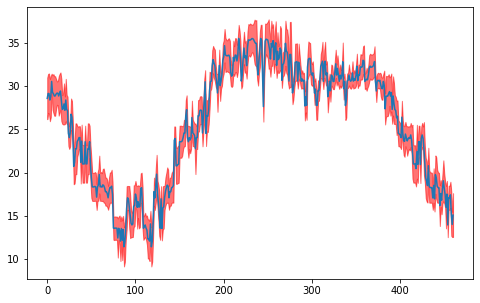

In [45]:
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

    
>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.
```python
df = pd.read_csv("DailyDelhiClimateTest.csv")
```

In [46]:
df = pd.read_csv("DailyDelhiClimateTest.csv")
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [47]:
print("Bagging no regularizado", min(val_br_val ))
print("Baggin regularizado: ", min(val_bnr_val ))
print("Adaboost no regularizado: ", min(val_adanr_val))
print("Adaboost regularizado: ", min(val_adar_val))
print("Random forest no regularizado: ",min(val_rfnreg))
print("Random forest regularizado: ", min(val_rfreg))

Bagging no regularizado 1.6593435528229208
Baggin regularizado:  1.5573589111285728
Adaboost no regularizado:  1.7197648588943617
Adaboost regularizado:  1.6614836807745907
Random forest no regularizado:  1.677933495176071
Random forest regularizado:  1.5568911027227614


Al ver los resultados anteriores podemos observar que el mejor modelo según RMSE es el adaboost cuando se regularizaron sus parametros, además podemos ver que al regularizar los parametros siempre se vio una mejora tomando en cuenta la comparación del error cuadratico medio.

<a id="refs"></a>
## Referencias
[1] https://scikit-learn.org/stable/modules/ensemble.html  
[2] https://scikit-learn.org/stable/modules/tree.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[4] https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18